# Event Log

## Imports

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Load Data

In [27]:
data_path = "../data/Docklands.csv" 
df = pd.read_csv(data_path, dtype={"DeviceId": str, "In Violation": int, "Vehicle Present": int})

# Consider only areas with one hour parking limit
# df.dropna(subset=["Sign"], inplace=True)

# Fix date format
df['ArrivalTime'] = pd.to_datetime(df['ArrivalTime'].astype(str))
df['DepartureTime'] = pd.to_datetime(df['DepartureTime'].astype(str))
df.head()

KeyboardInterrupt: 

In [39]:
df['ArrivalTime'] = pd.to_datetime(df['ArrivalTime'])

In [28]:
# Remove events without cars
df = df[df["Vehicle Present"] == 1]

### Analyze data

In [29]:
# How many violations without a street sign?
violations = df[df["In Violation"] == 1.0]
violations["Sign"].isnull().sum()

3

In [31]:
(df["DurationSeconds"] < 0).sum()

127

In [32]:
df.sort_values(by=["ArrivalTime"], inplace=True)
#df[df['StreetMarker'] == "13763W"].drop(columns=["Area", "StreetId", "StreetName", "BetweenStreet1",  "BetweenStreet2", "Side Of Street"])[:10]
#df_clean = df[df["Vehicle Present"] == 1]

df[df_clean['StreetMarker'] == "13018N"].drop(columns=["Area", "StreetId", "StreetName", "BetweenStreet1",  "BetweenStreet2", "Side Of Street"])[:15]

<ipython-input-32-ea84eda1ea62>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df_clean['StreetMarker'] == "13018N"].drop(columns=["Area", "StreetId", "StreetName", "BetweenStreet1",  "BetweenStreet2", "Side Of Street"])[:15]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

### Add Max Hours allowed by sign

In [34]:
df["Sign"] = df["Sign"].replace({np.nan: "None"})

df["MaxMinutes"] = np.select(
    [
        df["Sign"].str.startswith("None"), 
        df["Sign"].str.startswith("P5"),
        df["Sign"].str.startswith("P10"),
        df["Sign"].str.startswith("P/10"),
        df["Sign"].str.startswith("1/4P"),  
        df["Sign"].str.startswith("1/2P"),  
        df["Sign"].str.startswith("1/2"), 
        df["Sign"].str.startswith("1P"),
        df["Sign"].str.startswith("2P"),
        df["Sign"].str.startswith("3P"),
        df["Sign"].str.startswith("4P"),
        df["Sign"].str.startswith("LZ 15M"),
        df["Sign"].str.startswith("LZ 30M"),  
        df["Sign"].str.contains("60mins"), 
        df["Sign"].str.contains("30MINS"), 
        df["Sign"].str.contains("15mins"), 
        df["Sign"].str.contains("15Mins"), 
        df["Sign"].str.contains("1PMTR"),
    ], 
    [
        "None",
        5,
        10,
        10,
        15,
        30,
        30,
        60, 
        120,
        180,
        240,
        15,
        30,
        60,
        30,
        15,
        15,
        60
    ], 
    default="Unknown"
)

df["MaxMinutes"].value_counts()

120        895480
None       672609
15         326777
30         204452
60         123315
10         118160
5           64167
180         26593
240         22838
Unknown     10441
Name: MaxMinutes, dtype: int64

In [36]:
# Drop rows with unknown sign
df = df[df["MaxMinutes"] != "Unknown"]
df = df[df["MaxMinutes"] != "None"]
df['MaxMinutes'] = df['MaxMinutes'].astype(float)

### Test if starstwith and contains makes any difference

In [6]:
print(df["Sign"].str.contains("2P").sum())
print(df["Sign"].str.startswith("2P").sum())

895480
895480


In [7]:
print(df["Sign"].str.startswith("1/2").sum())
print(df["Sign"].str.contains("1/2").sum())
print(df["Sign"].str.startswith("1/2P").sum())
print(df["Sign"].str.contains("1/2P").sum())

0
0
0
0


In [8]:
# Test if starstwith and contains makes any difference
print(df["Sign"].str.contains("30MINS").sum())
print(df["Sign"].str.contains("15mins").sum())
print(df["Sign"].str.contains("15Mins").sum())
print(df["Sign"].str.contains("1PMTR").sum())

24600
13718
0
0


## Test how many violations are "false"

In [13]:
df_clean = df[df["MaxMinutes"] != "Unknown"]
df_clean = df_clean[df_clean["MaxMinutes"] != "None"]
df_clean["MaxMinutes"] = df_clean["MaxMinutes"].astype(int)
df_clean["MaxSeconds"] = df_clean["MaxMinutes"] * 60

# Remove unused columns
df_clean.drop(columns=["Area", "StreetId", "StreetName", "BetweenStreet1",  "BetweenStreet2", "Side Of Street"], inplace=True)


In [14]:
# Car overstayed, but no violation was recorded
df_overstayed = df_clean[df_clean["MaxSeconds"] < df_clean["DurationSeconds"]]
df_overstayed[df_overstayed["In Violation"] == 0]

,Unnamed: 0,DeviceId,ArrivalTime,DepartureTime,DurationSeconds,StreetMarker,Sign,In Violation,Vehicle Present,MaxMinutes,MaxSeconds
7,76,17188,2017-09-22 10:55:45,2017-09-22 11:11:50,965,13021S,LZ 15M M-SAT 7:30-18:30,0,1,15,900
23,249,17728,2017-12-11 13:07:37,2017-12-11 13:17:58,621,13922E,P10 AOT,0,1,10,600
54,467,17174,2017-04-18 16:33:46,2017-04-18 16:53:11,1165,13007S,LZ 15M M-SUN 7:30-19:30,0,1,15,900
94,756,17357,2017-07-05 11:43:08,2017-07-05 11:58:45,937,13320E,1/4P M-SUN 0:00-23:59,0,1,15,900
111,861,17429,2017-09-26 12:34:12,2017-09-26 12:51:09,1017,13408E,LZ 15mins 7.30 - 22.00,0,1,15,900
...,...,...,...,...,...,...,...,...,...,...,...
4900388,353509,17721,2017-09-18 21:46:26,2017-09-18 21:57:17,651,13915W,P/10 M-SUN 0:00-23:59 - No Park,0,1,10,600
4900454,353974,17261,2017-07-14 10:04:57,2017-07-14 11:07:54,3777,13220N,1P M-SUN 7:30-23:00,0,1,60,3600
4900551,354655,17430,2017-10-10 12:04:49,2017-10-10 12:22:34,1065,13410E,LZ 15mins 7.30 - 22.00,0,1,15,900
4900582,354843,17514,2017-10-17 13:44:51,2017-10-17 14:15:27,1836,13644E,LZ 30M 722 M-Su 7:30-18:30,0,1,30,1800


In [15]:
# Car overstayed, but no violation was recorded
# 5 minute grace period
df_overstayed = df_clean[df_clean["MaxSeconds"]+300 < df_clean["DurationSeconds"]]
df_overstayed[df_overstayed["In Violation"] == 0]

,Unnamed: 0,DeviceId,ArrivalTime,DepartureTime,DurationSeconds,StreetMarker,Sign,In Violation,Vehicle Present,MaxMinutes,MaxSeconds
937,6948,17170,2017-12-25 12:04:49,2017-12-25 12:27:39,1370,13001S,P/10 M-SUN 5:00-11:59 - No Park,0,1,10,600
1169,8752,17500,2017-04-25 13:44:08,2017-04-25 17:40:54,14206,13630E,2P MTR M-SAT 7:30-18:30,0,1,120,7200
1186,8883,17442,2017-03-13 08:18:46,2017-03-13 18:15:50,35824,13430E,P5 M-SUN 7:30-18:30,0,1,5,300
1569,11449,17608,2017-01-02 15:11:11,2017-01-02 17:52:04,9653,13766E,2P TKT A M-SAT 7:30-18:30,0,1,120,7200
1601,11650,17262,2017-01-26 18:57:25,2017-01-26 19:30:00,1955,13221S,P10 M-SUN 7:30-19:30,0,1,10,600
...,...,...,...,...,...,...,...,...,...,...,...
4899158,344536,17510,2017-03-13 07:37:02,2017-03-13 17:13:27,34585,13640E,2P MTR M-SAT 7:30-18:30,0,1,120,7200
4899255,345210,17388,2017-01-01 15:59:32,2017-01-01 18:30:00,9028,13348E,2P SUN 7:30-18:30,0,1,120,7200
4899295,345503,17700,2017-11-07 16:23:59,2017-11-07 17:08:04,2645,13870N,LZ 30M 722 M-Su 7:30-18:30,0,1,30,1800
4899964,350490,17480,2017-01-01 14:58:31,2017-01-01 18:30:00,12689,13508E,2P SUN 7:30-18:30,0,1,120,7200


In [17]:
# Car did not overstay, but violation was recorded
df_overstayed = df_clean[df_clean["MaxSeconds"] >= df_clean["DurationSeconds"]]
df_overstayed[df_overstayed["In Violation"] == 1]

,Unnamed: 0,DeviceId,ArrivalTime,DepartureTime,DurationSeconds,StreetMarker,Sign,In Violation,Vehicle Present,MaxMinutes,MaxSeconds
610474,284523,17726,2017-10-01 00:50:24,2017-10-01 01:00:00,576,13920E,P10 AOT,1,1,10,600
1442211,104669,17374,2017-12-09 07:30:00,2017-09-12 08:06:26,-7601014,13336E,LZ 30M 722 M-Su 7:30-18:30,1,1,30,1800
4136651,201148,17460,2017-10-01 01:06:11,2017-10-01 01:00:14,-357,13468E,1/4P M-SUN 0:00-23:59,1,1,15,900


# Creating the Event Log

## Extract Arrivals, Departures and Violations

In [20]:
arrivals = df[["ArrivalTime", "StreetMarker"]].copy()
arrivals.rename({"ArrivalTime": "Time"}, axis=1, inplace=True)
arrivals["Type"] = "Arrival"
arrivals.dropna(inplace=True)
arrivals

,Time,StreetMarker,Type
0,2017-02-09 16:57:38,13836N,Arrival
1,2017-09-27 09:43:31,13642E,Arrival
3,2017-10-20 09:54:01,C13596,Arrival
4,2017-07-27 11:25:02,13085S,Arrival
5,2017-03-12 13:31:15,13270N,Arrival
...,...,...,...
999995,2017-02-25 08:34:07,13403W,Arrival
999996,2017-01-21 11:28:55,13404E,Arrival
999997,2017-05-18 13:57:09,13398E,Arrival
999998,2017-12-27 09:16:25,13226N,Arrival


In [21]:
departures = df[['DepartureTime', 'StreetMarker']].copy()
departures.rename({"DepartureTime": "Time"}, axis=1, inplace=True)
departures["Type"] = "Departure"
departures.dropna(inplace=True)
departures

,Time,StreetMarker,Type
0,2017-02-09 17:11:04,13836N,Departure
1,2017-09-27 10:21:51,13642E,Departure
3,2017-10-20 12:34:02,C13596,Departure
4,2017-07-27 11:25:27,13085S,Departure
5,2017-03-12 13:32:08,13270N,Departure
...,...,...,...
999995,2017-02-25 08:42:07,13403W,Departure
999996,2017-01-21 11:50:01,13404E,Departure
999997,2017-05-18 14:50:50,13398E,Departure
999998,2017-12-27 09:24:59,13226N,Departure


### Violations

In [40]:
violations = df[df["In Violation"] == 1.0][['ArrivalTime', 'StreetMarker', "MaxMinutes"]]
violations["Time"] = violations.apply(lambda x: x["ArrivalTime"] + pd.DateOffset(minutes=x["MaxMinutes"]), axis=1)
violations.drop(['ArrivalTime'], axis=1, inplace=True)
violations["Type"] = "Violation"
violations

,StreetMarker,MaxMinutes,Time,Type
548574,13918E,10.0,2017-01-01 02:01:00,Violation
3333681,13920E,10.0,2017-01-01 14:08:04,Violation
2915333,13418E,10.0,2017-01-01 14:08:50,Violation
4330250,13922E,10.0,2017-01-01 15:03:45,Violation
3868581,13922E,10.0,2017-01-01 03:04:32,Violation
...,...,...,...,...
3717937,13264N,15.0,2017-12-31 13:10:55,Violation
2030116,13210N,60.0,2017-12-31 13:57:28,Violation
2901207,13808N,15.0,2017-12-31 13:12:29,Violation
1392753,13829S,120.0,2017-12-31 14:59:19,Violation


In [41]:
violations = df[df["In Violation"] == 1.0][['ArrivalTime', 'StreetMarker', "MaxMinutes"]].copy()
violations["Time"] = violations.apply(lambda x: x["ArrivalTime"] + pd.DateOffset(minutes=x["MaxMinutes"]), axis=1)
violations.drop(['ArrivalTime'], axis=1, inplace=True)
violations["Type"] = "Violation"
violations

,StreetMarker,MaxMinutes,Time,Type
548574,13918E,10.0,2017-01-01 02:01:00,Violation
3333681,13920E,10.0,2017-01-01 14:08:04,Violation
2915333,13418E,10.0,2017-01-01 14:08:50,Violation
4330250,13922E,10.0,2017-01-01 15:03:45,Violation
3868581,13922E,10.0,2017-01-01 03:04:32,Violation
...,...,...,...,...
3717937,13264N,15.0,2017-12-31 13:10:55,Violation
2030116,13210N,60.0,2017-12-31 13:57:28,Violation
2901207,13808N,15.0,2017-12-31 13:12:29,Violation
1392753,13829S,120.0,2017-12-31 14:59:19,Violation


## Create Event Log

In [23]:
event_log = arrivals.append(departures).append(violations)
event_log.sort_values(by=["Time"], inplace=True)
event_log.reset_index(drop=True, inplace=True)
event_log.head()

,Time,StreetMarker,Type
0,2017-01-01,13352E,Arrival
1,2017-01-01,13282N,Arrival
2,2017-01-01,13349W,Arrival
3,2017-01-01,13052N,Arrival
4,2017-01-01,13762E,Arrival


### Analyze Event Log

<AxesSubplot:>

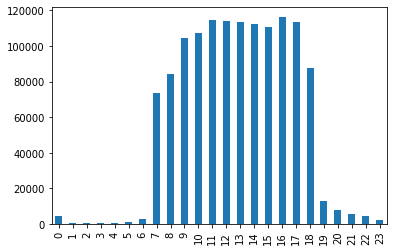

In [26]:
event_log['hour'] = event_log['Time'].dt.hour
event_log['hour'].value_counts(sort=False).plot(kind = 'bar')

<AxesSubplot:>

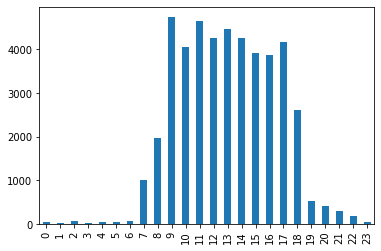

In [29]:
# Violations only
event_log[event_log["Type"] == "Violation"]['hour'].value_counts(sort=False).plot(kind = 'bar')

<AxesSubplot:>

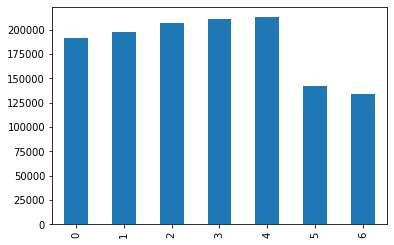

In [30]:
event_log['day'] = event_log['Time'].dt.weekday
event_log['day'].value_counts(sort=False).plot(kind = 'bar')